In [1]:
from google.colab import drive
drive.mount('/content/project')

Mounted at /content/project


In [2]:
!pip install shap

     |████████████████████████████████| 327kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456454 sha256=b2aa4ec87ae97e6033a2cd0209f9aa8d5a32ec28c3b5871674537511143d670c
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import shap
import pandas as pd
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

shap.initjs()

In [ ]:
df = pd.read_pickle("/content/project/My Drive/Doutorado/2020.1/Mineração de dados/ProjetoMD/preprocessed_pos")
df.head()

,Unnamed: 0,text,label,tweet_length,has_user,has_hashtag,has_url,tidy_tweet,tidy_tweet_tokens,tokens_no_stop
0,0,These girls are the equivalent of the irritati...,racism,99,False,True,False,these girls equivalent irritating asian girls ...,"[girl|NOUN, equivalent|ADJ, irritate|VERB, asi...","[girl|NOUN, equivalent|ADJ, irritate|VERB, asi..."
1,2,"Colin will save them. They're pretty blondes, ...",sexism,75,False,True,False,colin will save them they pretty blondes they ...,"[will|VERB, save|VERB, pretty|ADV, blonde|VERB...","[save|VERB, pretty|ADV, blonde|VERB, keep|VERB..."
2,5,Drasko they didn't cook half a bird you idiot ...,racism,50,False,True,False,drasko they didn cook half bird idiot,"[didn|VERB, cook|VERB, bird|NOUN, idiot|NOUN]","[cook|VERB, bird|NOUN, idiot|NOUN]"
3,9,Stop saying dumb blondes with pretty faces as ...,sexism,94,False,True,False,stop saying dumb blondes with pretty faces nee...,"[stop|VERB, say|VERB, dumb|ADJ, blonde|NOUN, w...","[stop|VERB, say|VERB, dumb|ADJ, blonde|NOUN, p..."
4,10,Obviously natural blondes!! #mkr,sexism,32,False,True,False,obviously natural blondes,"[obviously|ADV, natural|ADJ, blonde|NOUN]","[obviously|ADV, natural|ADJ, blonde|NOUN]"


In [ ]:
offensive_df = df[~df.label.isin(['none','normal','NOT'])]
offensive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 7120
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         3998 non-null   object
 1   text               3998 non-null   object
 2   label              3998 non-null   object
 3   tweet_length       3998 non-null   int64 
 4   has_user           3998 non-null   bool  
 5   has_hashtag        3998 non-null   bool  
 6   has_url            3998 non-null   bool  
 7   tidy_tweet         3998 non-null   object
 8   tidy_tweet_tokens  3998 non-null   object
 9   tokens_no_stop     3998 non-null   object
dtypes: bool(3), int64(1), object(6)
memory usage: 261.6+ KB


In [ ]:
def identity_tokenizer(text):
    return text
vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,lowercase=False)
# vectorizer = CountVectorizer(tokenizer=identity_tokenizer,lowercase=False,binary=True)
X = vectorizer.fit_transform(df['tokens_no_stop'].values)

X.shape

(7134, 8409)

In [ ]:
y = np.zeros((len(df['text'])))
for idx, row in df.iterrows():
    if row['label'] not in ['none' ,'normal','NOT']:
        y[idx] = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Decision Tree

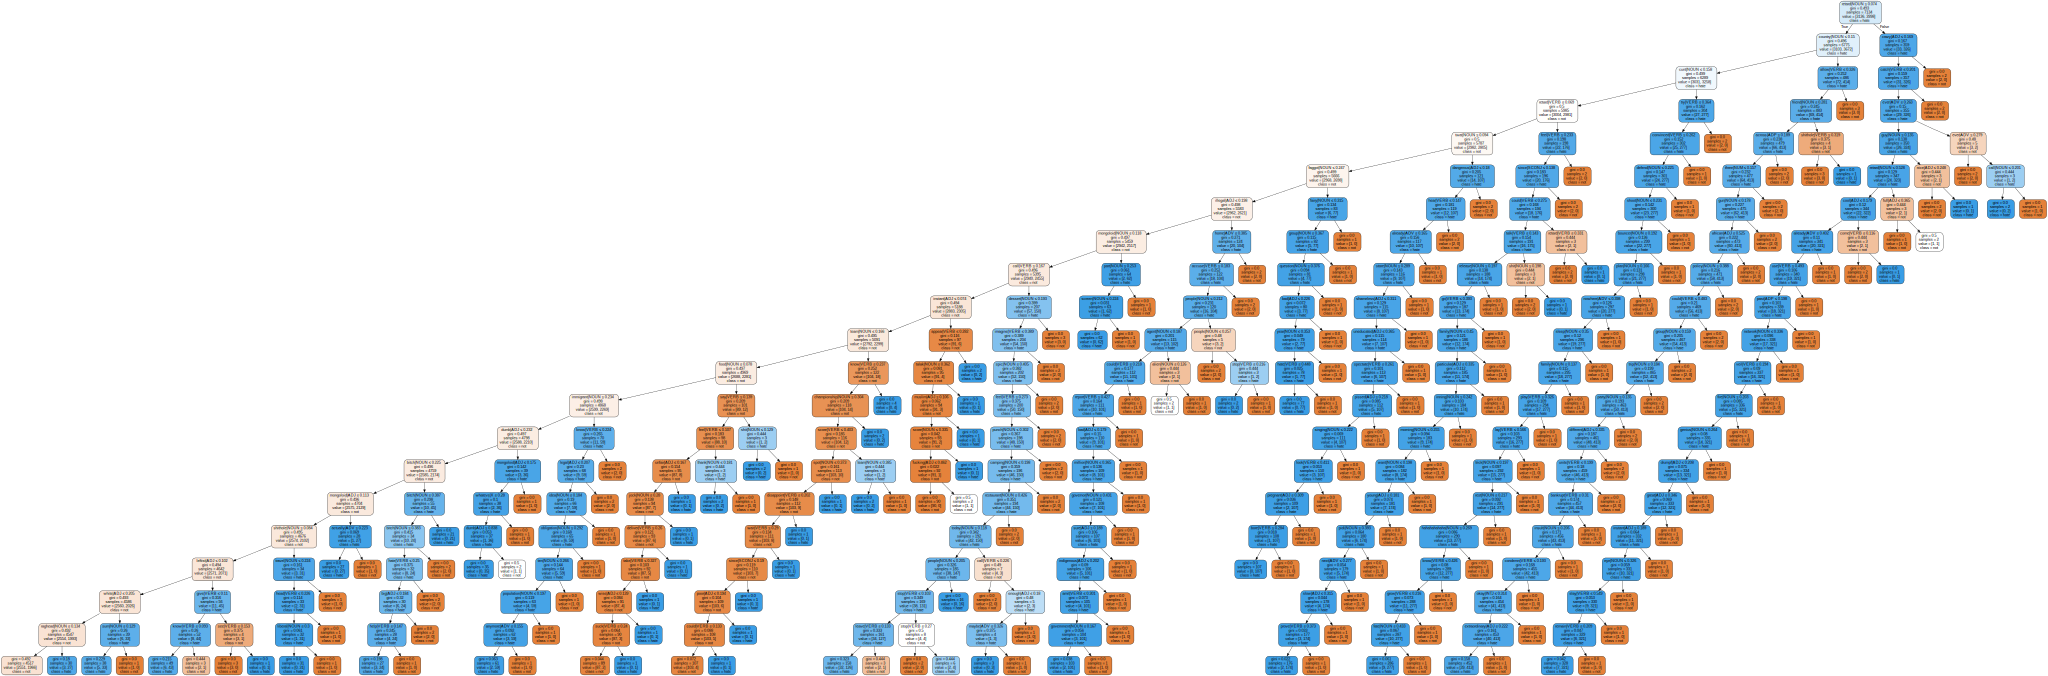

In [ ]:
from sklearn import tree
from IPython.display import display
import graphviz

clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=20)
clf = clf.fit(X, y)

dot_data = tree.export_graphviz(clf, out_file=None,
    class_names=['not','hate'],
    feature_names=vectorizer.get_feature_names(),
    filled=True, rounded=True,  special_characters=True) 

graph = graphviz.Source(dot_data) 
graph.render("./twitter_data/tree_tfidf_new") 

display(graphviz.Source(dot_data))

### Interative plot

In [ ]:
labels = vectorizer.get_feature_names()

def plot_tree(crit, split, depth, min_split):
    estimator = tree.DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split)
    estimator.fit(X, y)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=labels
      , class_names=['not','hate']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

In [ ]:
inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[3,5,10,20,30,40]
   , min_split=(0,10)
  )

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## Fit a linear logistic regression model


### Find C best value

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.01, 0.05,0.1,0.15, 0.25, 0.5, 1,2,3,4,5,6,7,8]
}
lr = sklearn.linear_model.LogisticRegression()
model = GridSearchCV(lr, parameters)
model.fit(X_train, y_train)
model.best_params_

lr_tfidf = sklearn.linear_model.LogisticRegression()
model_tfidf = GridSearchCV(lr_tfidf, parameters)
model_tfidf.fit(X_train_tfidf, y_train_tfidf)
model_tfidf.best_params_

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

{'C': 1}

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['not','hate']))

              precision    recall  f1-score   support

         not       0.74      0.69      0.72       622
        hate       0.77      0.81      0.79       805

    accuracy                           0.76      1427
   macro avg       0.76      0.75      0.75      1427
weighted avg       0.76      0.76      0.76      1427



## Explain model


In [ ]:
explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray()

### Summarize the effect of all the features


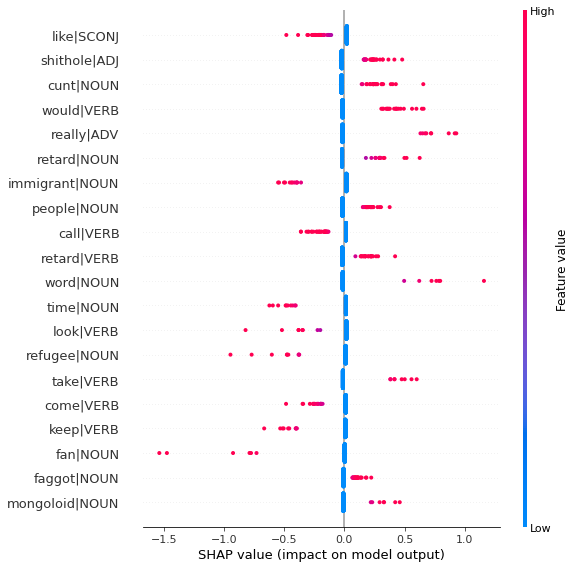

In [ ]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

### Explain the first tweet's sentiment prediction


In [ ]:
ind = 2
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [ ]:
ind = 1
shap.initjs()
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

## Evaluation


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy_score(y_test,y_pred)

0.7603363700070077

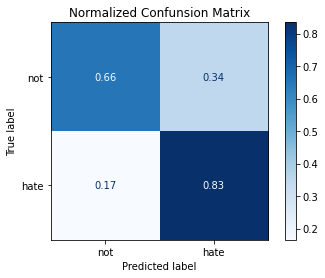

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix



disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['not','hate'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Normalized Confunsion Matrix")

plt.show()


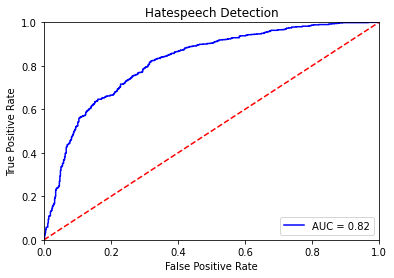

In [ ]:
probabilities = model.predict_proba(X_test)
predictions = probabilities[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Hatespeech Detection')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

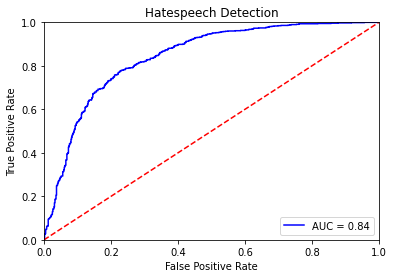

In [ ]:
probabilities_tfidf = model_tfidf.predict_proba(X_test_tfidf)
predictions_tfidf = probabilities_tfidf[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test_tfidf, predictions_tfidf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Hatespeech Detection')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Rule induction

In [ ]:
!pip install skope-rules

In [ ]:
from skrules import SkopeRules
feature_names = vectorizer.get_feature_names()
clf = SkopeRules(max_depth_duplication=2,
                 n_estimators=30,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=feature_names)
for idx, species in enumerate(['not','hate']):
    print(idx)
    clf.fit(X.toarray(), y == idx)
    rules = clf.rules_[0:3]
    print("Rules for", species)
    for rule in rules:
        print(rule[0])
    print()
    print(20*'=')
    print()

0
Rules for not
country|NOUN <= 0.15026818215847015 and cunt|NOUN <= 0.0798170194029808 and retard|NOUN <= 0.07412594556808472


1
Rules for hate
country|NOUN <= 0.1666337177157402 and cunt|NOUN <= 0.0742110162973404 and retard|NOUN <= 0.17714381963014603
country|NOUN > 0.15026818215847015 and gun|NOUN <= 0.17797592282295227 and party|NOUN <= 0.1346161961555481
country|NOUN > 0.15076089650392532 and allow|VERB <= 0.2869526967406273 and retard|NOUN <= 0.07412594556808472




In [ ]:
clf = SkopeRules(max_depth_duplication=2,
                 n_estimators=50,
                 precision_min=0.3,
                 recall_min=0.1,
                 feature_names=feature_names)
 
clf.fit(X.toarray(), y)
print(str(len(clf.rules_)) + ' rules have been built.')
print('The 5 most precise rules are the following:')
for rule in clf.rules_[:5]:
    print(rule[0])

5 rules have been built.
The 5 most precise rules are the following:
cunt <= 0.1565503254532814 and retard <= 0.054020095616579056 and shithole <= 0.07821889966726303
country <= 0.16978172957897186 and cunt <= 0.15994946658611298 and retard <= 0.054020095616579056
like <= 0.4166748374700546 and retard > 0.054020095616579056 and tweet <= 0.1425664722919464
could <= 0.2731434851884842 and ever <= 0.35354386270046234 and retard > 0.054020095616579056
country > 0.14508534222841263 and allow <= 0.2858586758375168 and retard <= 0.054020095616579056


In [ ]:
for rule in clf.rules_[:5]:
    print(rule)

('country <= 0.20166968554258347 and cunt <= 0.17326635867357254 and retard <= 0.0626334473490715', (0.4896276595744681, 0.7185792349726776, 1))
('cunt <= 0.18593930453062057 and retard <= 0.061050545424222946 and shithole <= 0.07821889966726303', (0.4844614758462563, 0.7184978839480683, 3))
('retard > 0.061050545424222946 and say <= 0.3241298198699951 and call <= 0.2818001061677933', (0.9342770145062409, 0.12914574345770974, 2))
('decision <= 0.17954641580581665 and line <= 0.1683923304080963 and retard > 0.0626334473490715', (0.9310344827586207, 0.12745869394177814, 1))
('country > 0.12727849185466766 and cunt <= 0.17326635867357254 and retard <= 0.061050545424222946', (0.8545454545454545, 0.11163895486935867, 1))


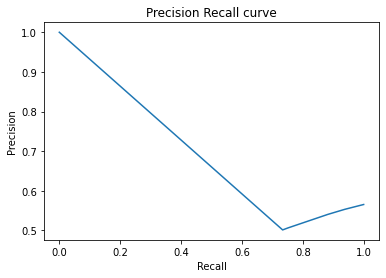

0.5365682137834037


In [ ]:
from sklearn.metrics import precision_recall_curve
y_score = clf.score_top_rules(X_test.toarray()) # Get a risk score for each test example
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall curve')
plt.show()

y_predict = clf.predict(X_test.toarray())
acc = accuracy_score(y_test,y_predict)
print(acc)

In [ ]:
a = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
a.head()

,aazadi,abdicate,abduct,abend,abet,abide,ability,able,ableist,abnormal,abortion,abroad,absence,absolute,absolutely,absorb,abstentionist,abstract,absurdly,abundance,abuse,abusive,abvp,academic,accent,accept,acceptable,accessible,accessory,accident,accidentally,accidently,accommodate,accomplish,accomplished,accord,accordingly,accost,accoster,account,...,xxxtentacion,yahoos,yappy,yaqui,yard,yarn,yawn,yayy,yayyy,yeah,year,yearly,yearsnwas,yell,yellow,yemeni,yesterday,yhahnglsdc,yield,yoke,yorker,young,younger,younus,yous,youth,youthful,youtuber,yukan,yummy,yuuuummmm,zakir,zealot,zeebie,zero,zionist,zomato,zone,zucchini,zyzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
